In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('bitcoin_data.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
df.shape

(3748, 7)

In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3748.000000,3748.000000,3748.000000,3748.000000,3748.000000,3.748000e+03
mean,19338.582332,19776.060513,18884.316684,19362.450791,19362.450791,1.850602e+10
std,21739.713467,22224.099574,21246.561576,21770.310921,21770.310921,2.031473e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,1219.367523,1235.844971,1204.585022,1221.882538,1221.882538,3.807000e+08
50%,9336.878418,9504.956055,9192.597656,9334.945312,9334.945312,1.456619e+10
75%,30419.344238,31006.337402,29927.467773,30427.529785,30427.529785,2.953873e+10
max,106147.296875,108268.445312,105291.734375,106140.601562,106140.601562,3.509679e+11


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3748 entries, 0 to 3747
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3748 non-null   object 
 1   Open       3748 non-null   float64
 2   High       3748 non-null   float64
 3   Low        3748 non-null   float64
 4   Close      3748 non-null   float64
 5   Adj Close  3748 non-null   float64
 6   Volume     3748 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 205.1+ KB


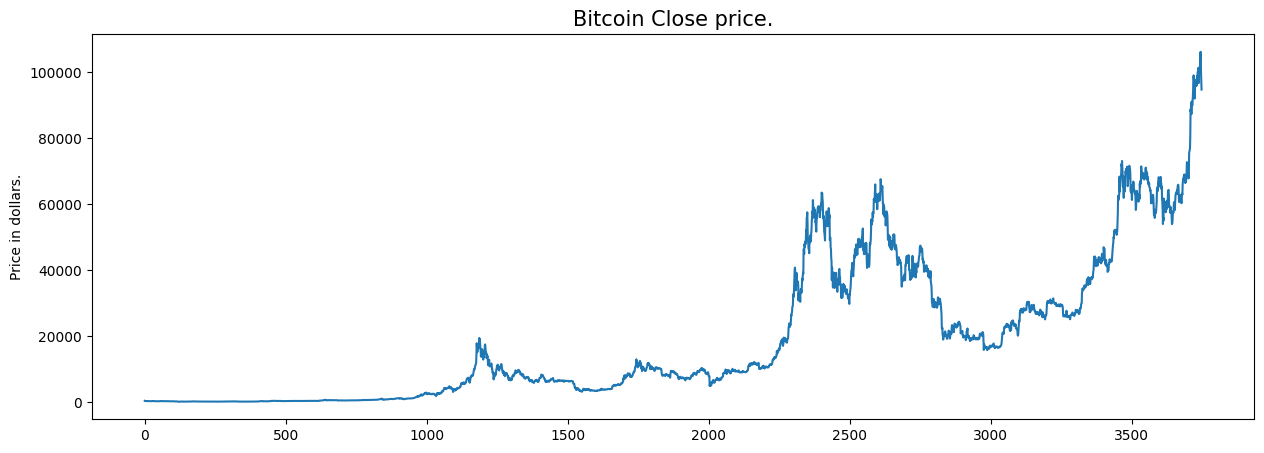

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.title('Bitcoin Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [7]:
df[df['Close'] == df['Adj Close']].shape, df.shape

((3748, 7), (3748, 7))

In [8]:
df = df.drop(['Adj Close'], axis=1)

In [9]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

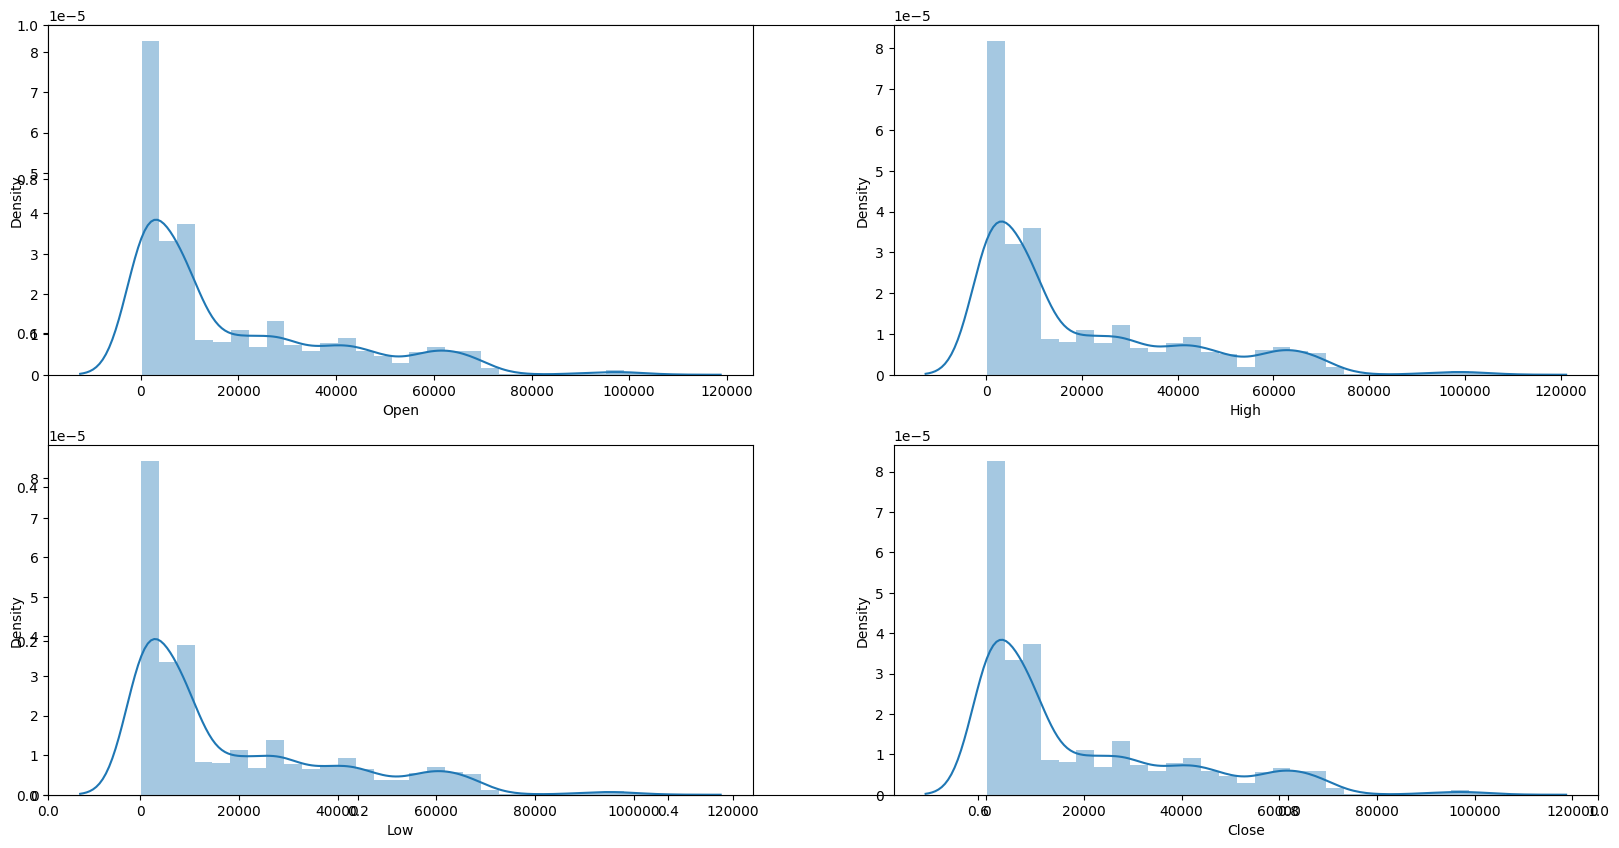

In [10]:
features = ['Open', 'High', 'Low', 'Close']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.distplot(df[col])
plt.show()

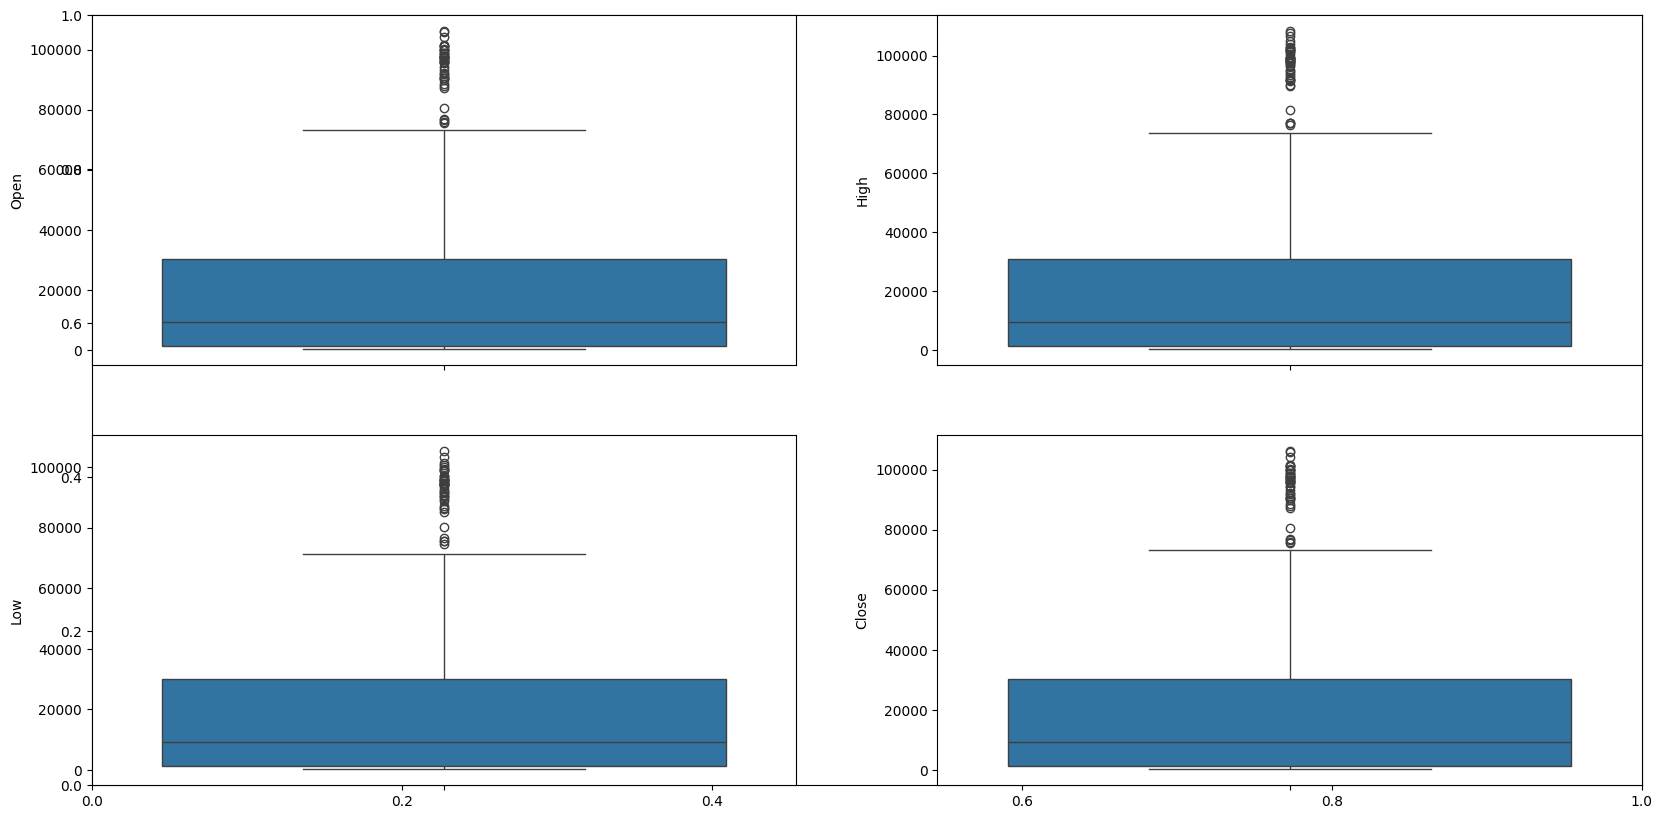

In [11]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.boxplot(df[col])
plt.show()

In [12]:
splitted = df['Date'].str.split('-', expand=True)

df['year'] = splitted[0].astype('int')
df['month'] = splitted[1].astype('int')
df['day'] = splitted[2].astype('int')

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Open,High,Low,Close,Volume,year,month,day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


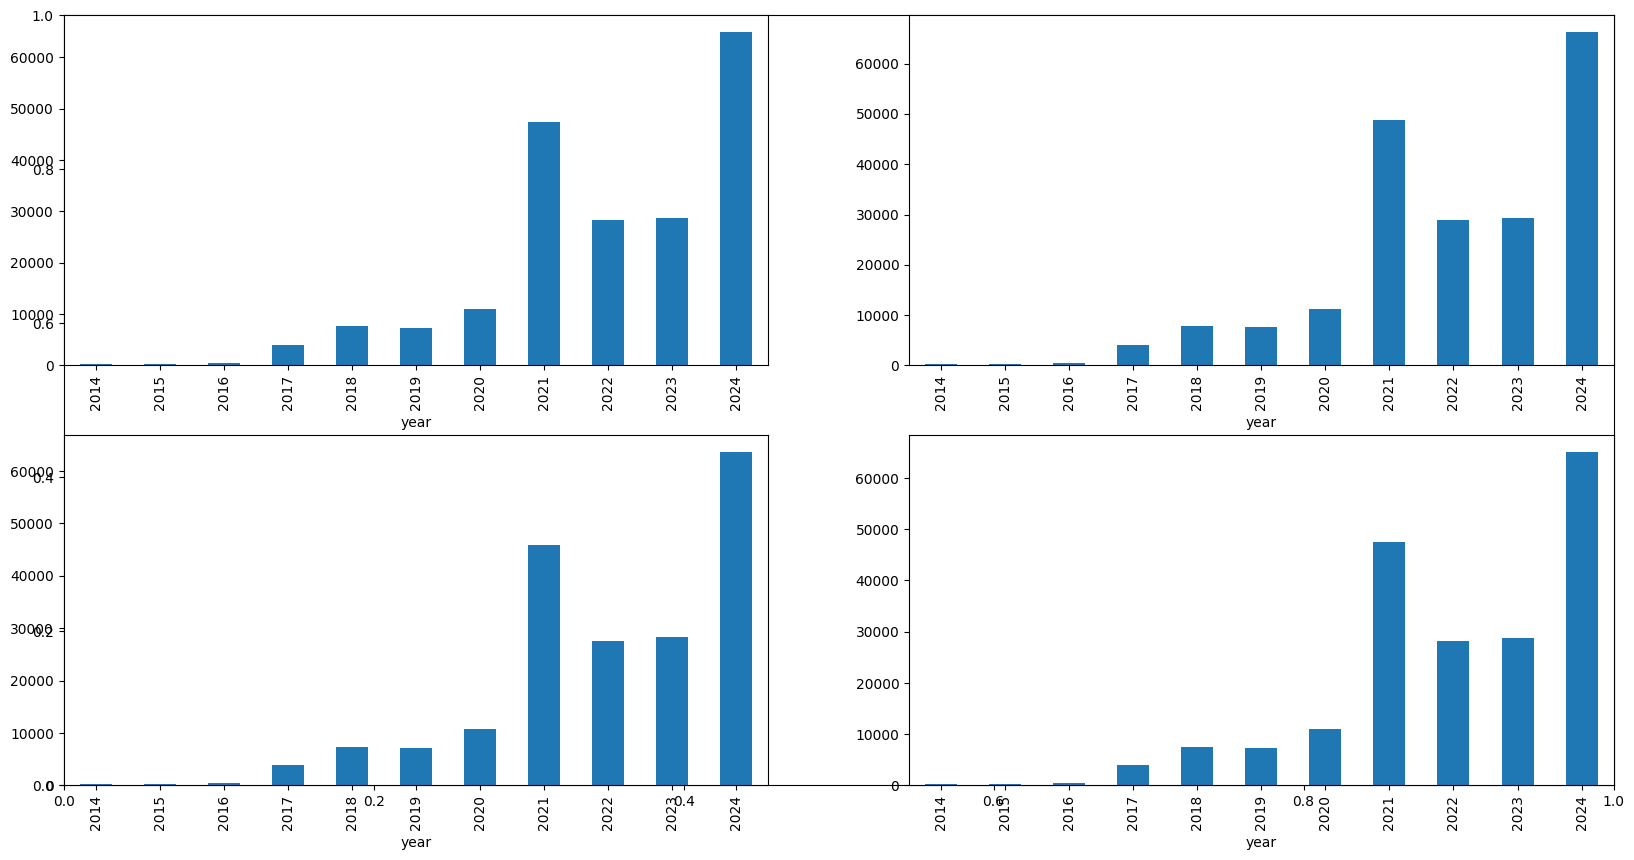

In [13]:
data_grouped = df.groupby('year').mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

In [14]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1


In [15]:
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

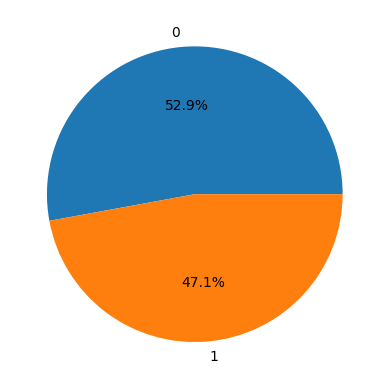

In [16]:
plt.pie(df['target'].value_counts().values,
		labels=[0, 1], autopct='%1.1f%%')
plt.show()

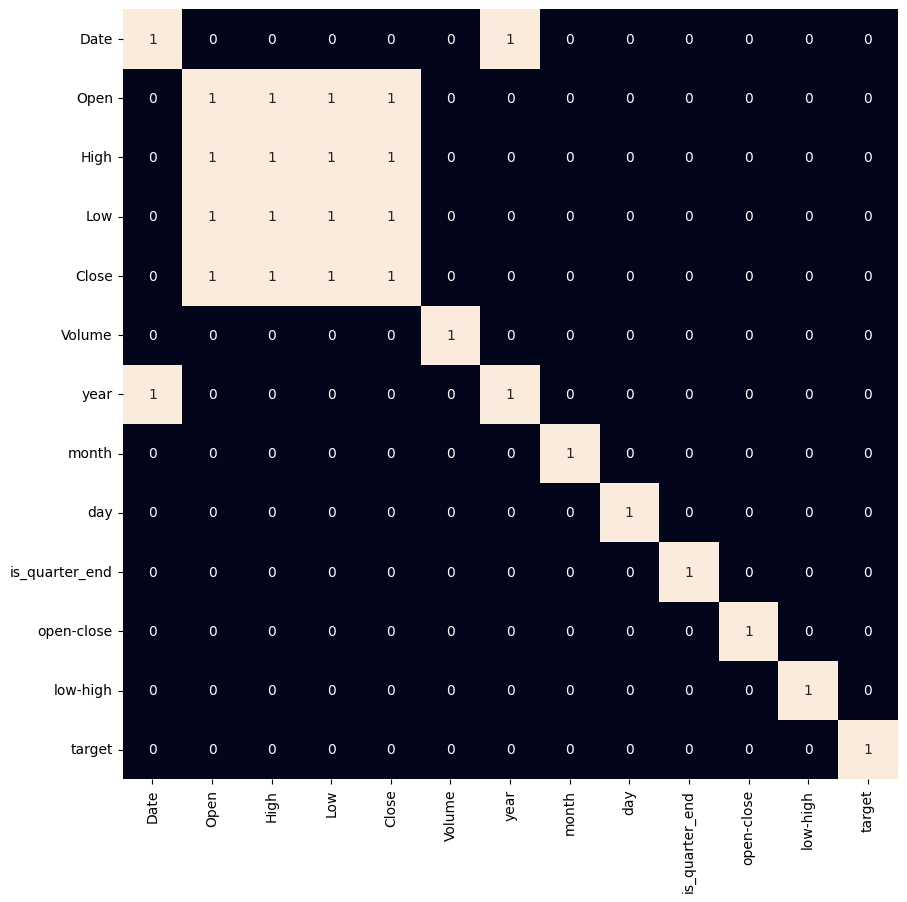

In [17]:
plt.figure(figsize=(10, 10))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

In [18]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
	features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(3373, 3) (375, 3)


In [19]:
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5339894199158759
Validation Accuracy :  0.49407137156538594

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.4758490563375014
Validation Accuracy :  0.5231159502907308

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training

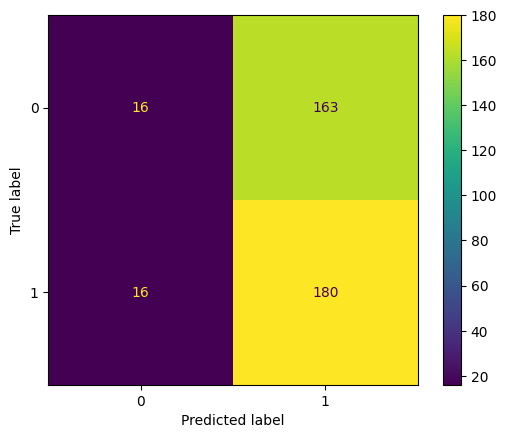

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_valid, Y_valid)
plt.show()

Prediction Function

In [21]:
def predict_target(model, input_data):
    """
    Predict the target (1 or 0) for a given input.

    Parameters:
    - model: Trained classification model
    - input_data: Array-like, shape (n_features,) or (n_samples, n_features)

    Returns:
    - Predicted class(es) and probabilities
    """
    # Ensure the input is scaled using the same scaler used during training
    input_data_scaled = scaler.transform([input_data] if len(input_data.shape) == 1 else input_data)
    predicted_class = model.predict(input_data_scaled)
    predicted_proba = model.predict_proba(input_data_scaled)
    
    return predicted_class, predicted_proba


In [22]:
# Example input: [open-close, low-high, is_quarter_end]
example_input = [150, 50, 1]  # Replace with actual values

# Select the best model (for example, LogisticRegression)
best_model = models[0]  # Assuming the first model is LogisticRegression

# Make prediction
predicted_class, predicted_proba = predict_target(best_model, np.array(example_input))

print(f"Predicted Class: {predicted_class[0]}")  # 0 or 1
print(f"Predicted Probability: {predicted_proba[0]}")  # [P(Class 0), P(Class 1)]


Predicted Class: 1
Predicted Probability: [0.46228884 0.53771116]


In [23]:
# Saving the model
import pickle

# Save the model
pickle.dump(best_model, open('bitcoin_model.pkl', 'wb'))

# Save the scaler
pickle.dump(scaler, open('b_scaler.pkl', 'wb'))


In [24]:
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end,open-close,low-high,target
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1,8.529999,-15.752014,0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1,32.419983,-43.755981,0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1,29.307007,-43.302979,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1,-14.230988,-33.412994,0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1,9.263977,-19.244995,1
